# Reflexer Model & Simulation

In [31]:
# Ensures source code is reloaded
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import matplotlib.pyplot as plt
from FixedPoint import FXnum
from decimal import Decimal
import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.plotting.backend = "plotly"

import sys
sys.path.append('./models')

from models.run import run
import models.options as options

## Debt Price Data Source

In [33]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

import os.path
from os import path

debt_price_source = options.DebtPriceSource.EXTERNAL.value
# debt_price_source = options.DebtPriceSource.DEFAULT.value
test_dfs = []

if debt_price_source == options.DebtPriceSource.EXTERNAL.value:
    if path.exists('./credentials/spreadsheet-credentials.json'):
        scope = [
            'https://spreadsheets.google.com/feeds',
            'https://www.googleapis.com/auth/drive'
        ]

        credentials = ServiceAccountCredentials.from_json_keyfile_name('credentials/spreadsheet-credentials.json', scope) # Your json file here
        gc = gspread.authorize(credentials)

        test_spreadsheet = gc.open('debt-price-test-data')
        print(gc.list_spreadsheet_files())

        worksheet_list = test_spreadsheet.worksheets()
        test_dfs = [pd.DataFrame(ws.get_all_values()[1:], columns=ws.get_all_values()[0]).copy() for ws in worksheet_list]
    else:
        debt_price_dataframe = pd.read_csv('./test/data/default_debt_price_source.csv')
        test_dfs = [debt_price_dataframe]

[{'kind': 'drive#file', 'id': '1oESvLtgVD7Ww2LLf4qAT8jtZcjWJjV9KpMN5frP53Zk', 'name': 'debt-price-test-data', 'mimeType': 'application/vnd.google-apps.spreadsheet'}]


In [34]:
test_dfs[0].head()

,seconds_passed,price_move
0,0,0
1,5185,0
2,4571,0
3,4527,0
4,10071,0


## PI Controller Sweep

In [35]:
def step_dataframe(index, size, time_period=3600, length=720):
    '''
    Generates a dataframe given the `index` of the price_move, the `size` of the price_move,
    the `time_period` of the seconds_passed, and the `length` of the dataset
    '''
    return pd.DataFrame(
        np.array([[time_period, size] if i == index else [time_period, 0] for i in range(length)]),
        columns=['seconds_passed', 'price_move']
    )

# test_dfs = [step_dataframe(20, i) for i in np.around(np.arange(0.05, 1.0, 0.05), decimals=2)]
test_dfs = [step_dataframe(20, 0.5)]

len(test_dfs)

1

In [36]:
test_dfs[0].iloc[20]

seconds_passed    3600.0
price_move           0.5
Name: 20, dtype: float64

### PI Tuning

In [37]:
kp = [FXnum(.25/3600) * 0.4, FXnum(.25/3600) * 0.6, FXnum(.25/3600) * 0.8, FXnum(.25/3600), FXnum((.25/3600) * 1.2)]
kp = [FXnum(.25/3600) * 0.6, FXnum(.25/3600) * 0.65, FXnum(.25/3600) * 0.7, FXnum(.25/3600) * 0.75, FXnum(.25/3600) * 0.8]
kp = [FXnum(.25/3600) * 0.65, FXnum(.25/3600) * 0.66, FXnum(.25/3600) * 0.67, FXnum(.25/3600) * 0.68, FXnum(.25/3600) * 0.69, FXnum(.25/3600) * 0.7]
kp = [FXnum(.25/3600) * 0.66]

In [38]:
ki = [FXnum(.25/3600) * 0.8, FXnum(.25/3600**2), FXnum((.25/3600**2) * 1.2), FXnum((.25/3600**2) * 1.5), FXnum((.25/3600**2) * 1.2), FXnum((.25/3600**2) * 1.8), FXnum((.25/3600**2) * 2)]
ki = [FXnum(.25/3600**2), FXnum((.25/3600**2) * 0.2), FXnum((.25/3600**2) * 0.4), FXnum((.25/3600**2) * 0.6), FXnum((.25/3600**2) * 0.8)]
ki = [FXnum((.25/3600**2) * 2), FXnum((.25/3600**2) * 2.5), FXnum((.25/3600**2) * 3.0), FXnum((.25/3600**2) * 3.5), FXnum((.25/3600**2) * 4.0), FXnum((.25/3600**2) * 4.5)]
ki = [FXnum((.25/3600) * 10), FXnum((.25/3600) * 15), FXnum((.25/3600) * 20), FXnum((.25/3600) * 25), FXnum((.25/3600) * 30), FXnum((.25/3600) * 35)]

In [39]:
# 'kp': [FXnum(.25/3600)], #proportional term for the stability controller: units 1/second
# 'ki': [FXnum(.25/3600**2)], #integral term for the stability controller: units 1/seconds^2

# kp = [FXnum(i) for i in np.arange(0, (.25/3600) * 2, (.25/3600 * 2) / 5)]
# ki = [FXnum(i) for i in np.arange(0, (.25/3600**2) * 2, (.25/3600**2 * 2) / 5)]

kp = [FXnum(.25/3600)]
ki = [FXnum(.25/3600**2)]

kp = [FXnum(.25/3600) * 0.65, FXnum(.25/3600) * 0.66, FXnum(.25/3600) * 0.67, FXnum(.25/3600) * 0.68, FXnum(.25/3600) * 0.69, FXnum(.25/3600) * 0.7]
ki = [FXnum((.25/3600) * 10), FXnum((.25/3600) * 15), FXnum((.25/3600) * 20), FXnum((.25/3600) * 25), FXnum((.25/3600) * 30), FXnum((.25/3600) * 35)]

kp = [FXnum(.25/3600) * 0.66]
ki = [FXnum(10 * .25/3600)]

kp = [FXnum(.25/3600) * 0.1]
ki = [FXnum(10 * .25/3600)]

In [40]:
controller_sweep = list(itertools.product(kp, ki))
controller_sweep

[(FXnum(family=FXfamily(n_bits=64, n_intbits=None), scaled_value=128102389400761),
  FXnum(family=FXfamily(n_bits=64, n_intbits=None), scaled_value=12810238940076078))]

In [41]:
kp_sweep = [x[0] for x in controller_sweep]
ki_sweep = [x[1] for x in controller_sweep]

## Simulation Configuration

Set the simulation timesteps to the minimum dataset length:

In [42]:
minimum_timesteps = min([df.shape[0] for df in test_dfs])
SIMULATION_TIMESTEPS = range(minimum_timesteps)
SIMULATION_TIMESTEPS

range(0, 720)

Override certain parameter sweeps with the generated sets, using ConfigWrapper for convenience:

In [43]:
from models.config_wrapper import ConfigWrapper

import models.market_model as market_model
import models.controller_model as controller_model

# Update parameter options
update_params = {
    # By using an Enum, we can self-document all possible options
    options.DebtPriceSource.__name__: [debt_price_source],
    options.IntegralType.__name__: [options.IntegralType.LEAKY.value],
    # Generate a lambda for each test dataframe, that returns a row value at a specific timestep
    'seconds_passed': [
        lambda timestep, df=df.copy(): int(df.iloc[timestep - 1]['seconds_passed'])
        for df in test_dfs
    ],
    'price_move': [
        lambda timestep, df=df.copy(): float(df.iloc[timestep - 1]['price_move'])
        for df in test_dfs
    ],
    'kp': kp_sweep,
    'ki': ki_sweep,
    # Select or sweep the error term calculation, as a lambda
    # e.g. p*-p vs (p*-p)/p vs (p*-p)/p*
    'error_term': [
        lambda target, measured: target - measured,
        #lambda target, measured: (target - measured) / measured,
        #lambda target, measured: (target - measured) / target
    ]
}

'''
The ConfigWrapper allows you to pass a model as an argument, and update the simulation configuration.
Maps (params, states) would be merge updated, and all other options are overrides.
'''
market_simulation = ConfigWrapper(market_model, M=update_params, N=1, T=SIMULATION_TIMESTEPS)
# controller_simulation = ConfigWrapper(controller_model, M=update_params, N=1, T=SIMULATION_TIMESTEPS)

## Simulation Execution

In [44]:
from cadCAD import configs
del configs[:]

market_simulation.append()
# controller_simulation.append

(data, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (720, 21, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [1]
Execution Mode: single_threaded
Total execution time: 1.93s


In [45]:
'''
To save state data to CSV:
'''
# compression_opts = dict(method='zip', archive_name='data.csv')  
# data.to_csv('data.zip', index=False, compression=compression_opts)

'\nTo save state data to CSV:\n'

## Data Analysis

In [46]:
df = data.copy()
df

,index,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,...,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,2020-09-22 11:25:34.563418,0,0,0,1,0,0
1,6,0.002299999999999996491,0.002299999999999996491,0,0,0,4.139999999999993685051,0.000000638888888888835,0.000000638888888888835,-0.000000015972222222235,...,0.997700000000000003508,1,3600,2020-09-22 12:25:34.563418,240,0,0,1,6,1
2,12,0.003817313058648816618,0.003874811405555549895,0,0,0,15.254660529999977181848,0.000000421475849624638,0.000000421475849624638,-0.000000026509118462858,...,0.996125188594444450104,1,3600,2020-09-22 13:25:34.563418,480,0,0,1,6,2
3,18,0.004758488013626629509,0.004911409146464384338,0,0,0,31.069857523635858705460,0.000000261437487493812,0.000000261437487493812,-0.000000033045055650160,...,0.995088590853535615661,1,3600,2020-09-22 14:25:34.563418,720,0,0,1,6,3
4,24,0.005279833486608100816,0.005551691553312048776,0,0,0,49.903438783233438312547,0.000000144818186939251,0.000000144818186939251,-0.000000036665510323686,...,0.994448308446687951223,1,3600,2020-09-22 15:25:34.563418,960,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,4296,-0.001196033561844821473,0.011012619088848306608,0,0,0,98241.261259885724174277694,0.000000001224652867559,0.000000001224652867559,0.000000008305788623931,...,1.488987380911151693391,1.5,3600,2020-10-22 07:25:34.563418,171840,0,0,1,6,716
717,4302,-0.001191641124438359042,0.010972524651549289936,0,0,0,98280.834518618439847961222,0.000000001220121501771,0.000000001220121501771,0.000000008275285586390,...,1.489027475348450710063,1.5,3600,2020-10-22 08:25:34.563418,172080,0,0,1,6,717
718,4308,-0.001187264938699073978,0.010932576017888954371,0,0,0,98320.263699823428687617384,0.000000001215607149771,0.000000001215607149771,0.000000008244895407627,...,1.489067423982111045628,1.5,3600,2020-10-22 09:25:34.563418,172320,0,0,1,6,718
719,4314,-0.001182904943613984072,0.010892772658911836118,0,0,0,98359.549327441670110499724,0.000000001211109745857,0.000000001211109745857,0.000000008214617663990,...,1.489107227341088163881,1.5,3600,2020-10-22 10:25:34.563418,172560,0,0,1,6,719


In [47]:
FXcols = [
    'error_star',
    'error_hat',
    'old_error_star',
    'old_error_hat',
    'error_star_integral',
    'error_hat_integral',
    'error_star_derivative',
    'error_hat_derivative',
    'target_rate',
    'target_price',
    'market_price',
    'debt_price'
]

In [48]:
for c in FXcols:
    print(c)
    df[c] = df[c].apply(lambda x: float(x))

error_star
error_hat
old_error_star
old_error_hat
error_star_integral
error_hat_integral
error_star_derivative
error_hat_derivative
target_rate
target_price
market_price
debt_price


In [49]:
df['target_rate_hourly'] = df.target_rate * 3600
df['error_star_derivative_scaled'] = df.error_star_derivative * 3600
df['error_hat_derivative_scaled'] = df.error_star_derivative * 3600

In [50]:
import plotly.express as px

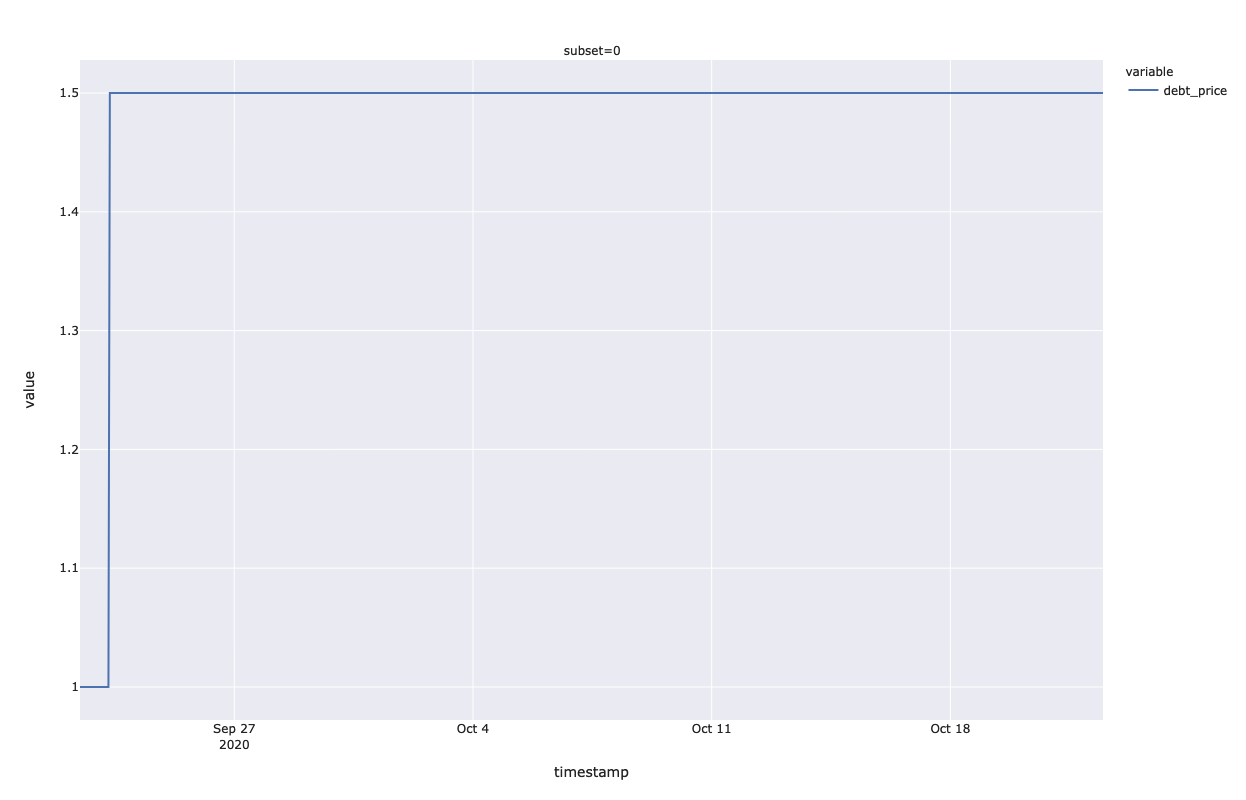

In [51]:
fig = px.line(
    df,
    x='timestamp',
    y=['debt_price'],
    facet_col='subset',
    facet_col_wrap=5,
    #facet_row='run',
    template='seaborn',
    height=800
)

fig.show()

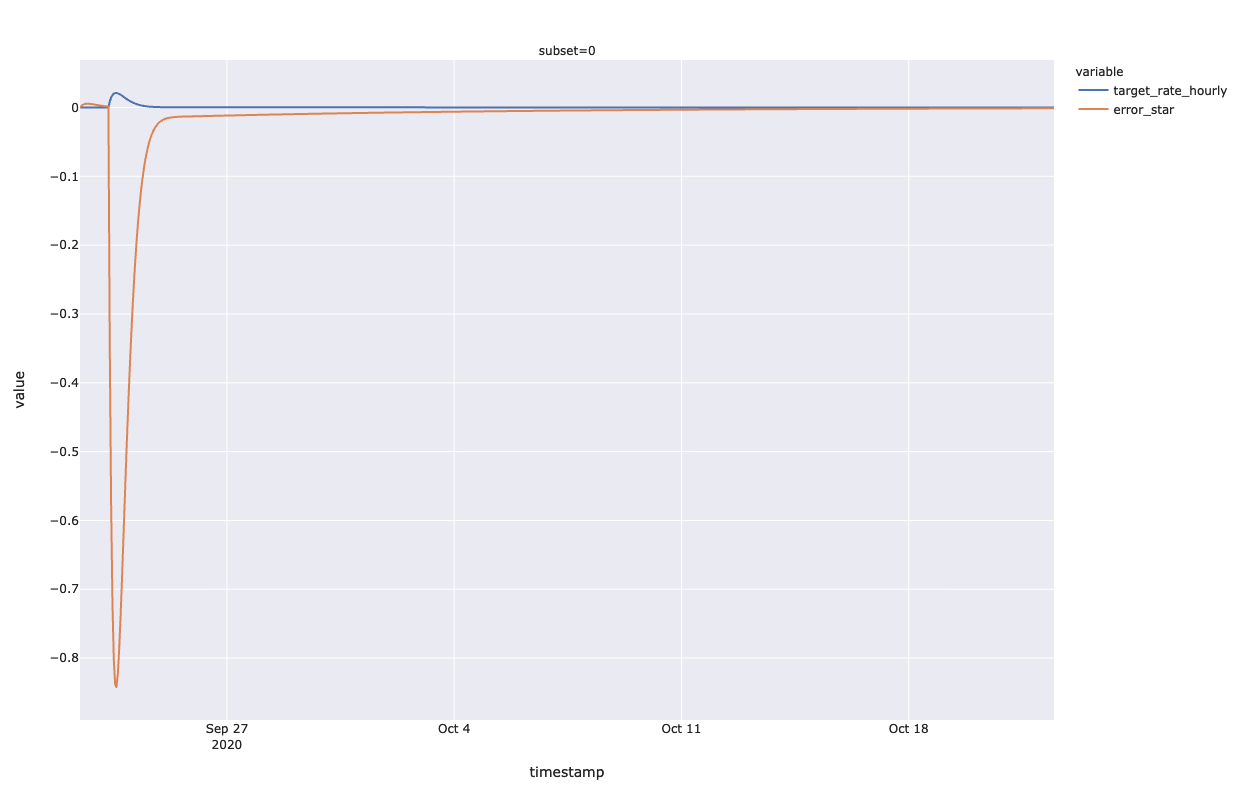

In [52]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_rate_hourly', 'error_star'],
    facet_col='subset',
    #facet_col='run',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.for_each_annotation(lambda a: a.update(text=f'''kp:{
#     "%.2E" % float(update_params["kp"][int(a.text.split("=")[-1])])
# }; ki:{
#     "%.2E" % float(update_params["ki"][int(a.text.split("=")[-1])])
# }'''))

fig.show()

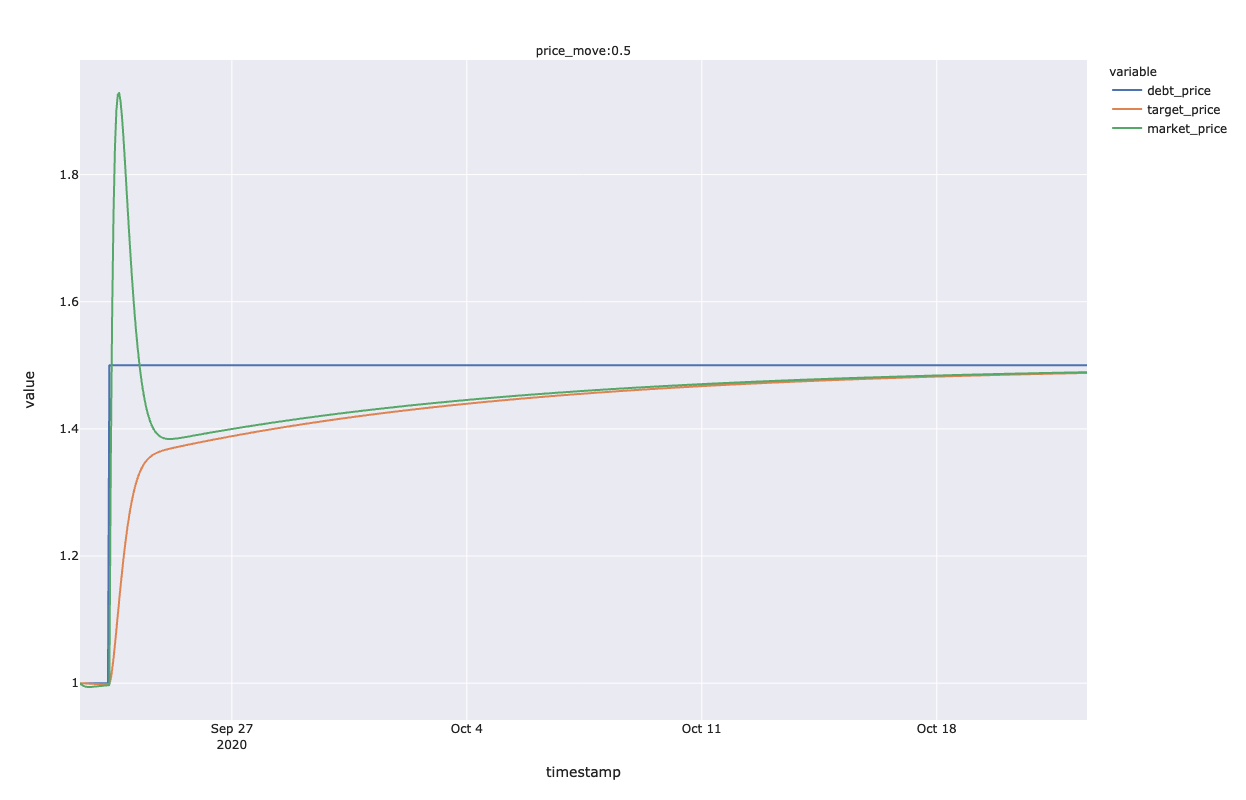

In [53]:
fig = px.line(
    df,
    x='timestamp',
    y=['debt_price', 'target_price', 'market_price'],
    facet_col='subset',
    facet_col_wrap=4,
    #facet_col='run',
    template='seaborn',
    height=800
)

# fig.for_each_annotation(lambda a: a.update(text=f'''kp:{
#     "%.2E" % float(update_params["kp"][int(a.text.split("=")[-1])])
# }; ki:{
#     "%.2E" % float(update_params["ki"][int(a.text.split("=")[-1])])
# }'''))
fig.for_each_annotation(lambda a: a.update(text=f'''price_move:{
    test_dfs[int(a.text.split("=")[-1])].price_move.max()
}'''))

fig.show()

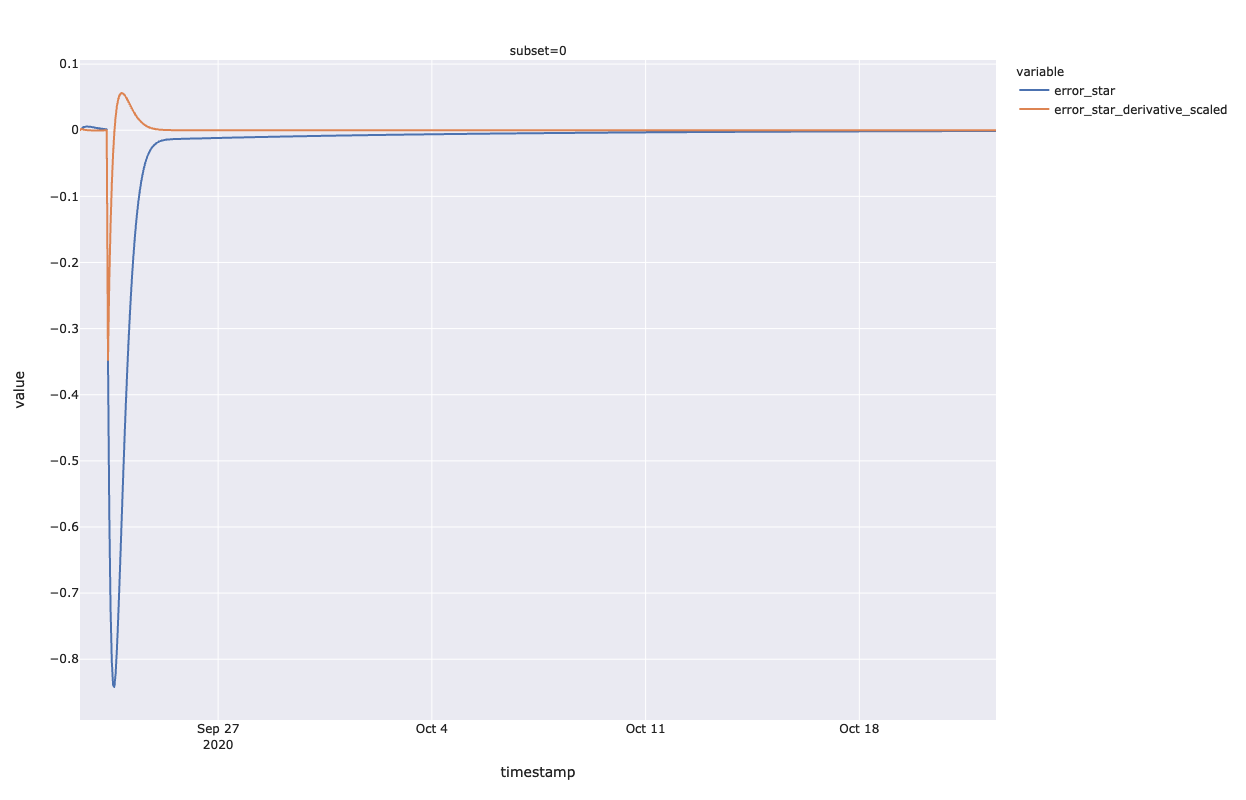

In [54]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star','error_star_derivative_scaled'],
    facet_col='subset',
    facet_col_wrap=4,
    #facet_col='run',
    template='seaborn',
    height=800
)

fig.show()

In [55]:
def integral_plot(df, subset=0):
    from matplotlib.patches import Rectangle
    
    df = df[df.subset == subset]

    df['seconds'] = df.timedelta.cumsum()

    x=df.seconds.values
    y=df.error_star.values
    h=(df.error_star.shift(periods=-1)+df.error_star)/2
    w=df.timedelta.values

    plt.figure(figsize=(18, 12))
    plt.plot(x,y , marker='.',linestyle='--', color='r')

    ax = plt.gca()

    for p in range(len(x)-1):
        ax.add_patch(
            Rectangle(
            (x[p], 0),
            w[p+1],
            h[p+1],
            edgecolor = 'blue',
            facecolor = 'cyan',
            fill=True
        ))

    plt.title('Visualizing Numerical Integration')
    plt.xlabel('Time passed in seconds')
    plt.ylabel('Observed Error')

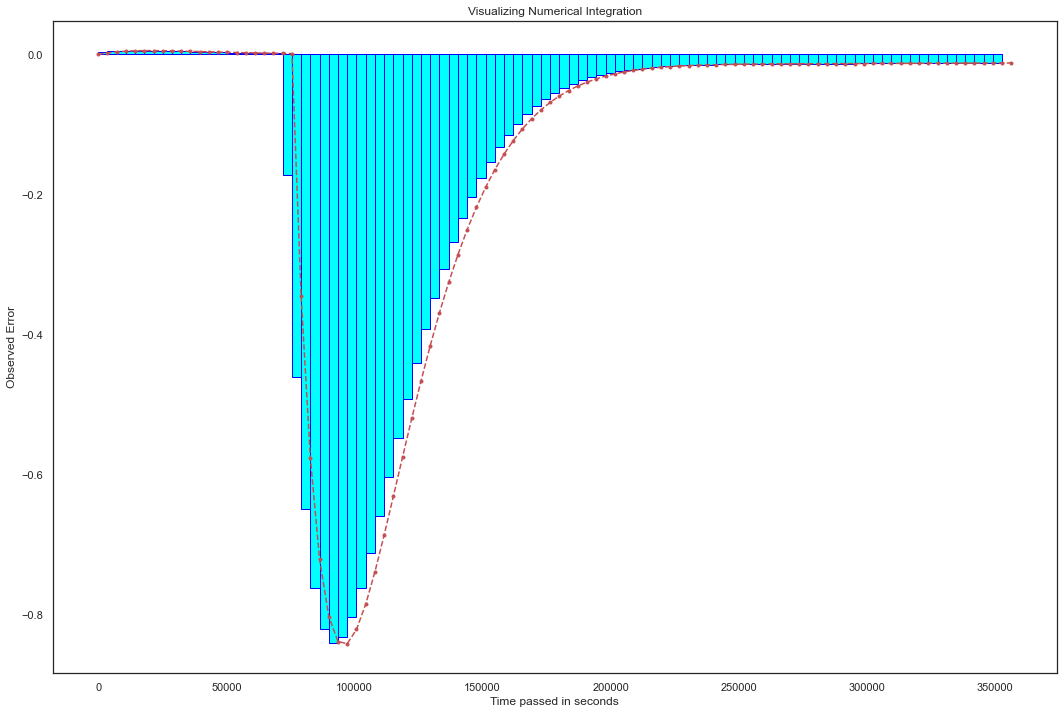

In [56]:
integral_plot(df[df.timestep<100])

Plotly `hist()` error, see: https://github.com/plotly/plotly.py/pull/2713

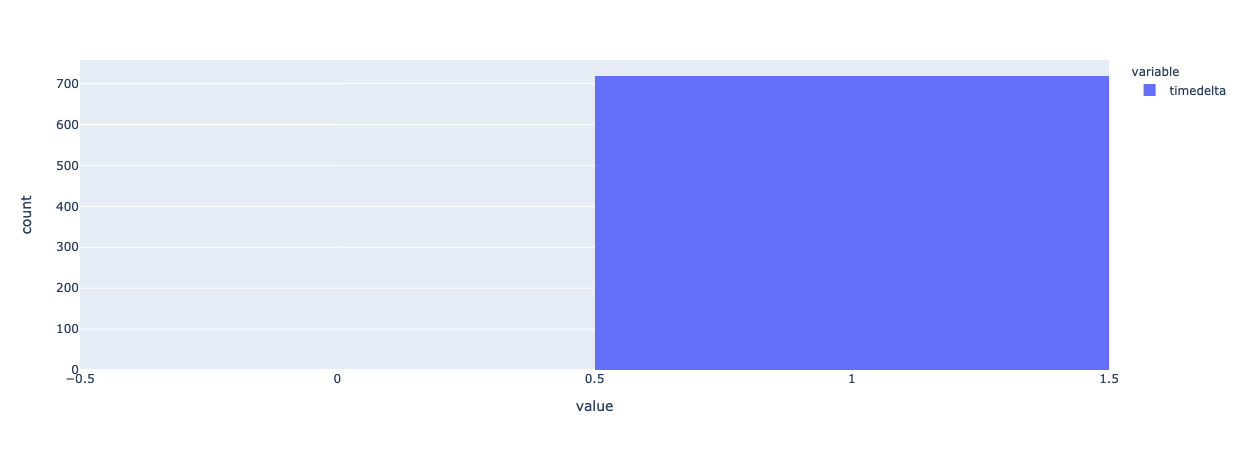

In [57]:
df.timedelta.apply(lambda x: x/3600).hist()

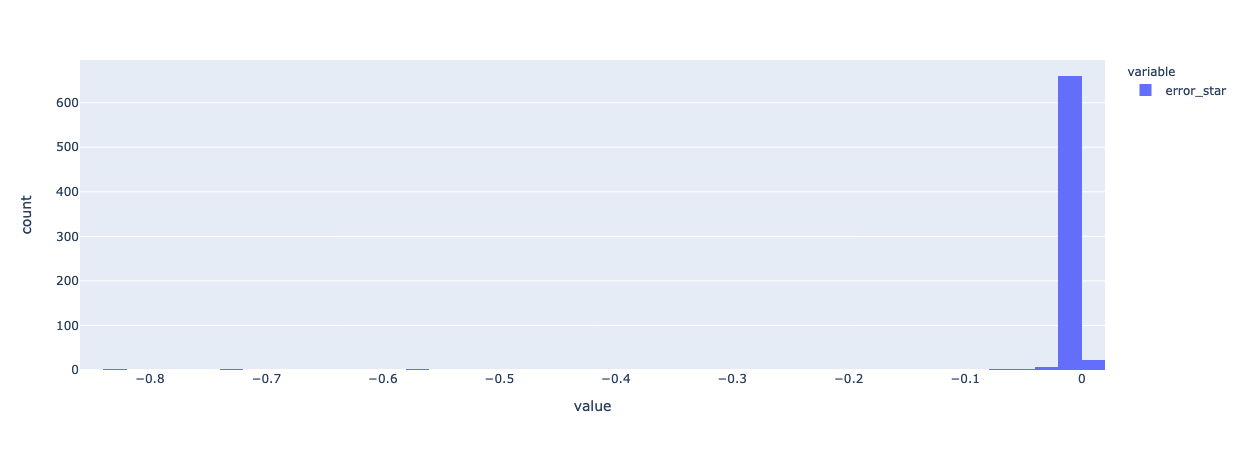

In [58]:
df.error_star.hist()

In [59]:
import seaborn as sns; sns.set(style="white", color_codes=True)

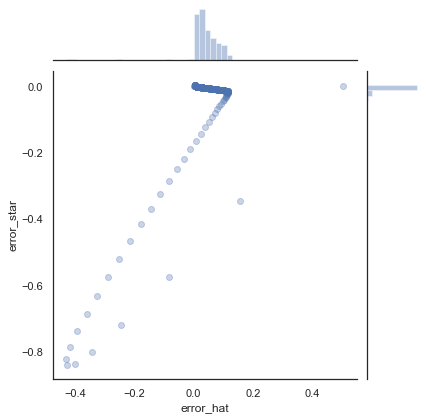

In [60]:
g = sns.jointplot(x="error_hat", y="error_star", alpha=.3, data=df[df.subset == 0])